In [ ]:
from langgraph.graph import START, END, StateGraph
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_openai import OpenAIEmbeddings
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from CONFIG import GROQ_MODEL, OPENAI_EMBEDDED_MODEL
from langchain_community.vectorstores import FAISS
from typing import TypedDict, List
from langchain_core.prompts import ChatPromptTemplate

In [2]:
load_dotenv()

True

In [3]:
# MODEL loaded

embedded_model = OpenAIEmbeddings(model=OPENAI_EMBEDDED_MODEL)
llm = ChatGroq(model=GROQ_MODEL)

In [4]:
# PDF loading

pdf = PyPDFLoader(file_path='A:\AI_Projects_Practice\CRAG\The_Evolution_of_AI_in_Dubai.pdf')
pdf_loaded = pdf.load()
print(f"PDF has {len(pdf_loaded)} pages")

PDF has 8 pages


In [5]:
# Chunking

chunks = RecursiveCharacterTextSplitter(chunk_size=900, chunk_overlap=100).split_documents(pdf_loaded)
print(f"Total chunks are {len(chunks)}")

Total chunks are 24


In [6]:
# Stored in vector database (FAISS)

vectore_storage = FAISS.from_documents(chunks, embedded_model)

In [7]:
# Retrieved based on similarity (k=2)

retriever = vectore_storage.as_retriever(search_type='similarity', search_kwargs={'k': 2})
for i in retriever.invoke('what about dubai'):
    print(i.page_content)
    print()
    print('*'*100)
    print()

Dubai AI Strategy: Introduced in 2017, this strategy aims to make Dubai a global hub for AI by
2031. It focuses on utilizing AI to optimize government operations, improve city services, and
advance economic development. It involves collaboration between governmental bodies and
private sectors to create an ecosystem that fosters AI innovation.
Smart Dubai: Under this initiative, the city aims to leverage AI technologies to provide better
public services. Key projects include AI-powered chatbots for government services, such as the
Dubai Corporation for Ambulance Services, which utilizes AI to optimize response times and
allocate resources more effectively based on real-time data.
Dubai AI Ethics Advisory Board: To ensure that the deployment of AI technologies is ethical
and transparent, this board was formed. It reviews AI projects for compliance with ethical

****************************************************************************************************

finance, and transportatio

In [8]:
class state(TypedDict):
    question: str
    answer: str
    doc: List[str]

In [9]:
def retrieved_str(state: state) -> str:
    q = state['question']
    return {'doc': retriever.invoke(q)}

In [11]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "Answer only from the context. If not in context, say you don't know."),
        ("human", "Question: {question}\n\nContext:\n{context}"),
    ]
)

def generate(state):
    context = "\n\n".join(d.page_content for d in state["doc"])
    out = (prompt | llm).invoke({"question": state["question"], "context": context})
    return {"answer": out.content}

In [12]:
graph = StateGraph(state)

graph.add_node('retrieved_str', retrieved_str)
graph.add_node('generate', generate)

graph.add_edge(START, 'retrieved_str')
graph.add_edge('retrieved_str', 'generate')
graph.add_edge('generate', END)

rag = graph.compile()

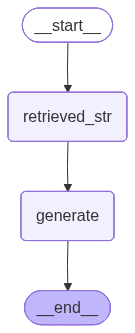

In [13]:
rag

In [14]:
res = rag.invoke(
    {
        'question': 'tell me Strategy of AI in UAE',
	  'doc': [],
	  'answer': ''
    }
)

In [15]:
res['answer']

'The strategy of AI in UAE, specifically in Dubai, is to make Dubai a global hub for AI by 2031. The key components of this strategy include:\n\n1. Infrastructural Development: Investing in tech infrastructure to support AI-driven services, such as high-speed internet and cloud computing resources.\n2. Sectoral Impact: Prioritizing sectors like healthcare, transportation, and education to improve services through AI.\n3. Collaboration: Between governmental bodies and private sectors to create an ecosystem that fosters AI innovation.\n4. Ethical Deployment: Ensuring the deployment of AI technologies is ethical and transparent through the Dubai AI Ethics Advisory Board.\n5. Optimizing Government Operations: Utilizing AI to optimize government operations, improve city services, and advance economic development.\n\nThe goal is to enhance government services, boost the economy, and improve the quality of life for residents and visitors by leveraging AI technologies.'

In [16]:
res['doc']

[Document(id='2c8ce0dc-b665-4286-9cae-e6aebd9c0a07', metadata={'producer': 'Skia/PDF m144', 'creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/144.0.0.0 Safari/537.36 Edg/144.0.0.0', 'creationdate': '2026-02-09T17:29:23+00:00', 'title': 'Untitled', 'moddate': '2026-02-09T17:29:23+00:00', 'source': 'A:\\AI_Projects_Practice\\CRAG\\The_Evolution_of_AI_in_Dubai.pdf', 'total_pages': 8, 'page': 2, 'page_label': '3'}, page_content='Dubai AI Strategy: Introduced in 2017, this strategy aims to make Dubai a global hub for AI by\n2031. It focuses on utilizing AI to optimize government operations, improve city services, and\nadvance economic development. It involves collaboration between governmental bodies and\nprivate sectors to create an ecosystem that fosters AI innovation.\nSmart Dubai: Under this initiative, the city aims to leverage AI technologies to provide better\npublic services. Key projects include AI-powered chatbots for government se